In [0]:
!pip -q install tensorflow-hub

In [0]:
import tensorflow as tf
import tensorflow_hub as hub

CHANNELS = 3 # number of image channels (RGB)

def build_graph(hub_module_url, target_image_path):
  # Step 1) Prepare pre-trained model for extracting image features.
  module = hub.Module(hub_module_url)
  height, width = hub.get_expected_image_size(module)

  # Copied a method of https://github.com/GoogleCloudPlatform/cloudml-samples/blob/bf0680726/flowers/trainer/model.py#L181
  # and fixed for all type images (not only jpeg)
  def decode_and_resize(image_str_tensor):
    """Decodes jpeg string, resizes it and returns a uint8 tensor."""
    image = tf.image.decode_jpeg(image_str_tensor, channels=CHANNELS)
    # Note resize expects a batch_size, but tf_map supresses that index,
    # thus we have to expand then squeeze.  Resize returns float32 in the
    # range [0, uint8_max]
    image = tf.expand_dims(image, 0)
    image = tf.image.resize(
        image, size=(height, width)) 
    image = tf.squeeze(image, axis=0) #
    image = tf.cast(image, dtype=tf.uint8)
    return image

  def to_img_feature(images):
    """Extract the feature of image vectors"""
    outputs = module(dict(images=images), signature="image_feature_vector", as_dict=True)
    return outputs['default']

  # Step 2) Extract image features of the target image.
  target_image_bytes = tf.io.gfile.GFile(target_image_path, 'rb').read()
  target_image = tf.constant(target_image_bytes, dtype=tf.string)
  target_image = decode_and_resize(target_image)
  target_image = tf.image.convert_image_dtype(target_image, dtype=tf.float32)
  target_image = tf.expand_dims(target_image, 0)
  target_image = to_img_feature(target_image)

  # Step 3) Extract image features of input images.
  input_byte = tf.compat.v1.placeholder(tf.string, shape=[None])
  input_image = tf.map_fn(decode_and_resize, input_byte, back_prop=False, dtype=tf.uint8)
  input_image = tf.image.convert_image_dtype(input_image, dtype=tf.float32)
  input_image = to_img_feature(input_image)

  # Step 4) Compare cosine_similarities of the target image and the input images.
  dot = tf.tensordot(target_image, tf.transpose(input_image), 1)
  similarity = dot / (tf.norm(target_image, axis=1) * tf.norm(input_image, axis=1))
  similarity = tf.reshape(similarity, [-1])
  
  return input_byte, similarity

In [0]:
target_image_url = "https://img.huffingtonpost.com/asset/5aaf2eff1f0000180316abd5.jpeg" #@param {type:"string"}
input_image1_url = "http://cdn.ppomppu.co.kr/zboard/data3/2020/0209/20200209185613_xsxihypc.jpeg" #@param {type:"string"}
input_image2_url = "https://img.huffingtonpost.com/asset/5eb3528530000085161558de.jpeg" #@param {type:"string"}
input_image3_url = "https://img.huffingtonpost.com/asset/5eb602012200005d12828676.jpeg" #@param {type:"string"}
input_image4_url = "https://img.huffingtonpost.com/asset/5e9ba7c22200009a078273d3.jpeg" #@param {type:"string"}

input_image_urls = [input_image1_url, input_image2_url, input_image3_url, input_image4_url]

target_img_path = 'target_img.jpeg'
input_img_paths = []

!wget -q {target_image_url} -O {target_img_path}

for i, url in enumerate(input_image_urls):
  if len(url) > 0:
    path = "input_img%d.jpeg" % i
    !wget -q {url} -O {path}
    input_img_paths.append(path)

5 images inference time: 0.71 s
# Target image


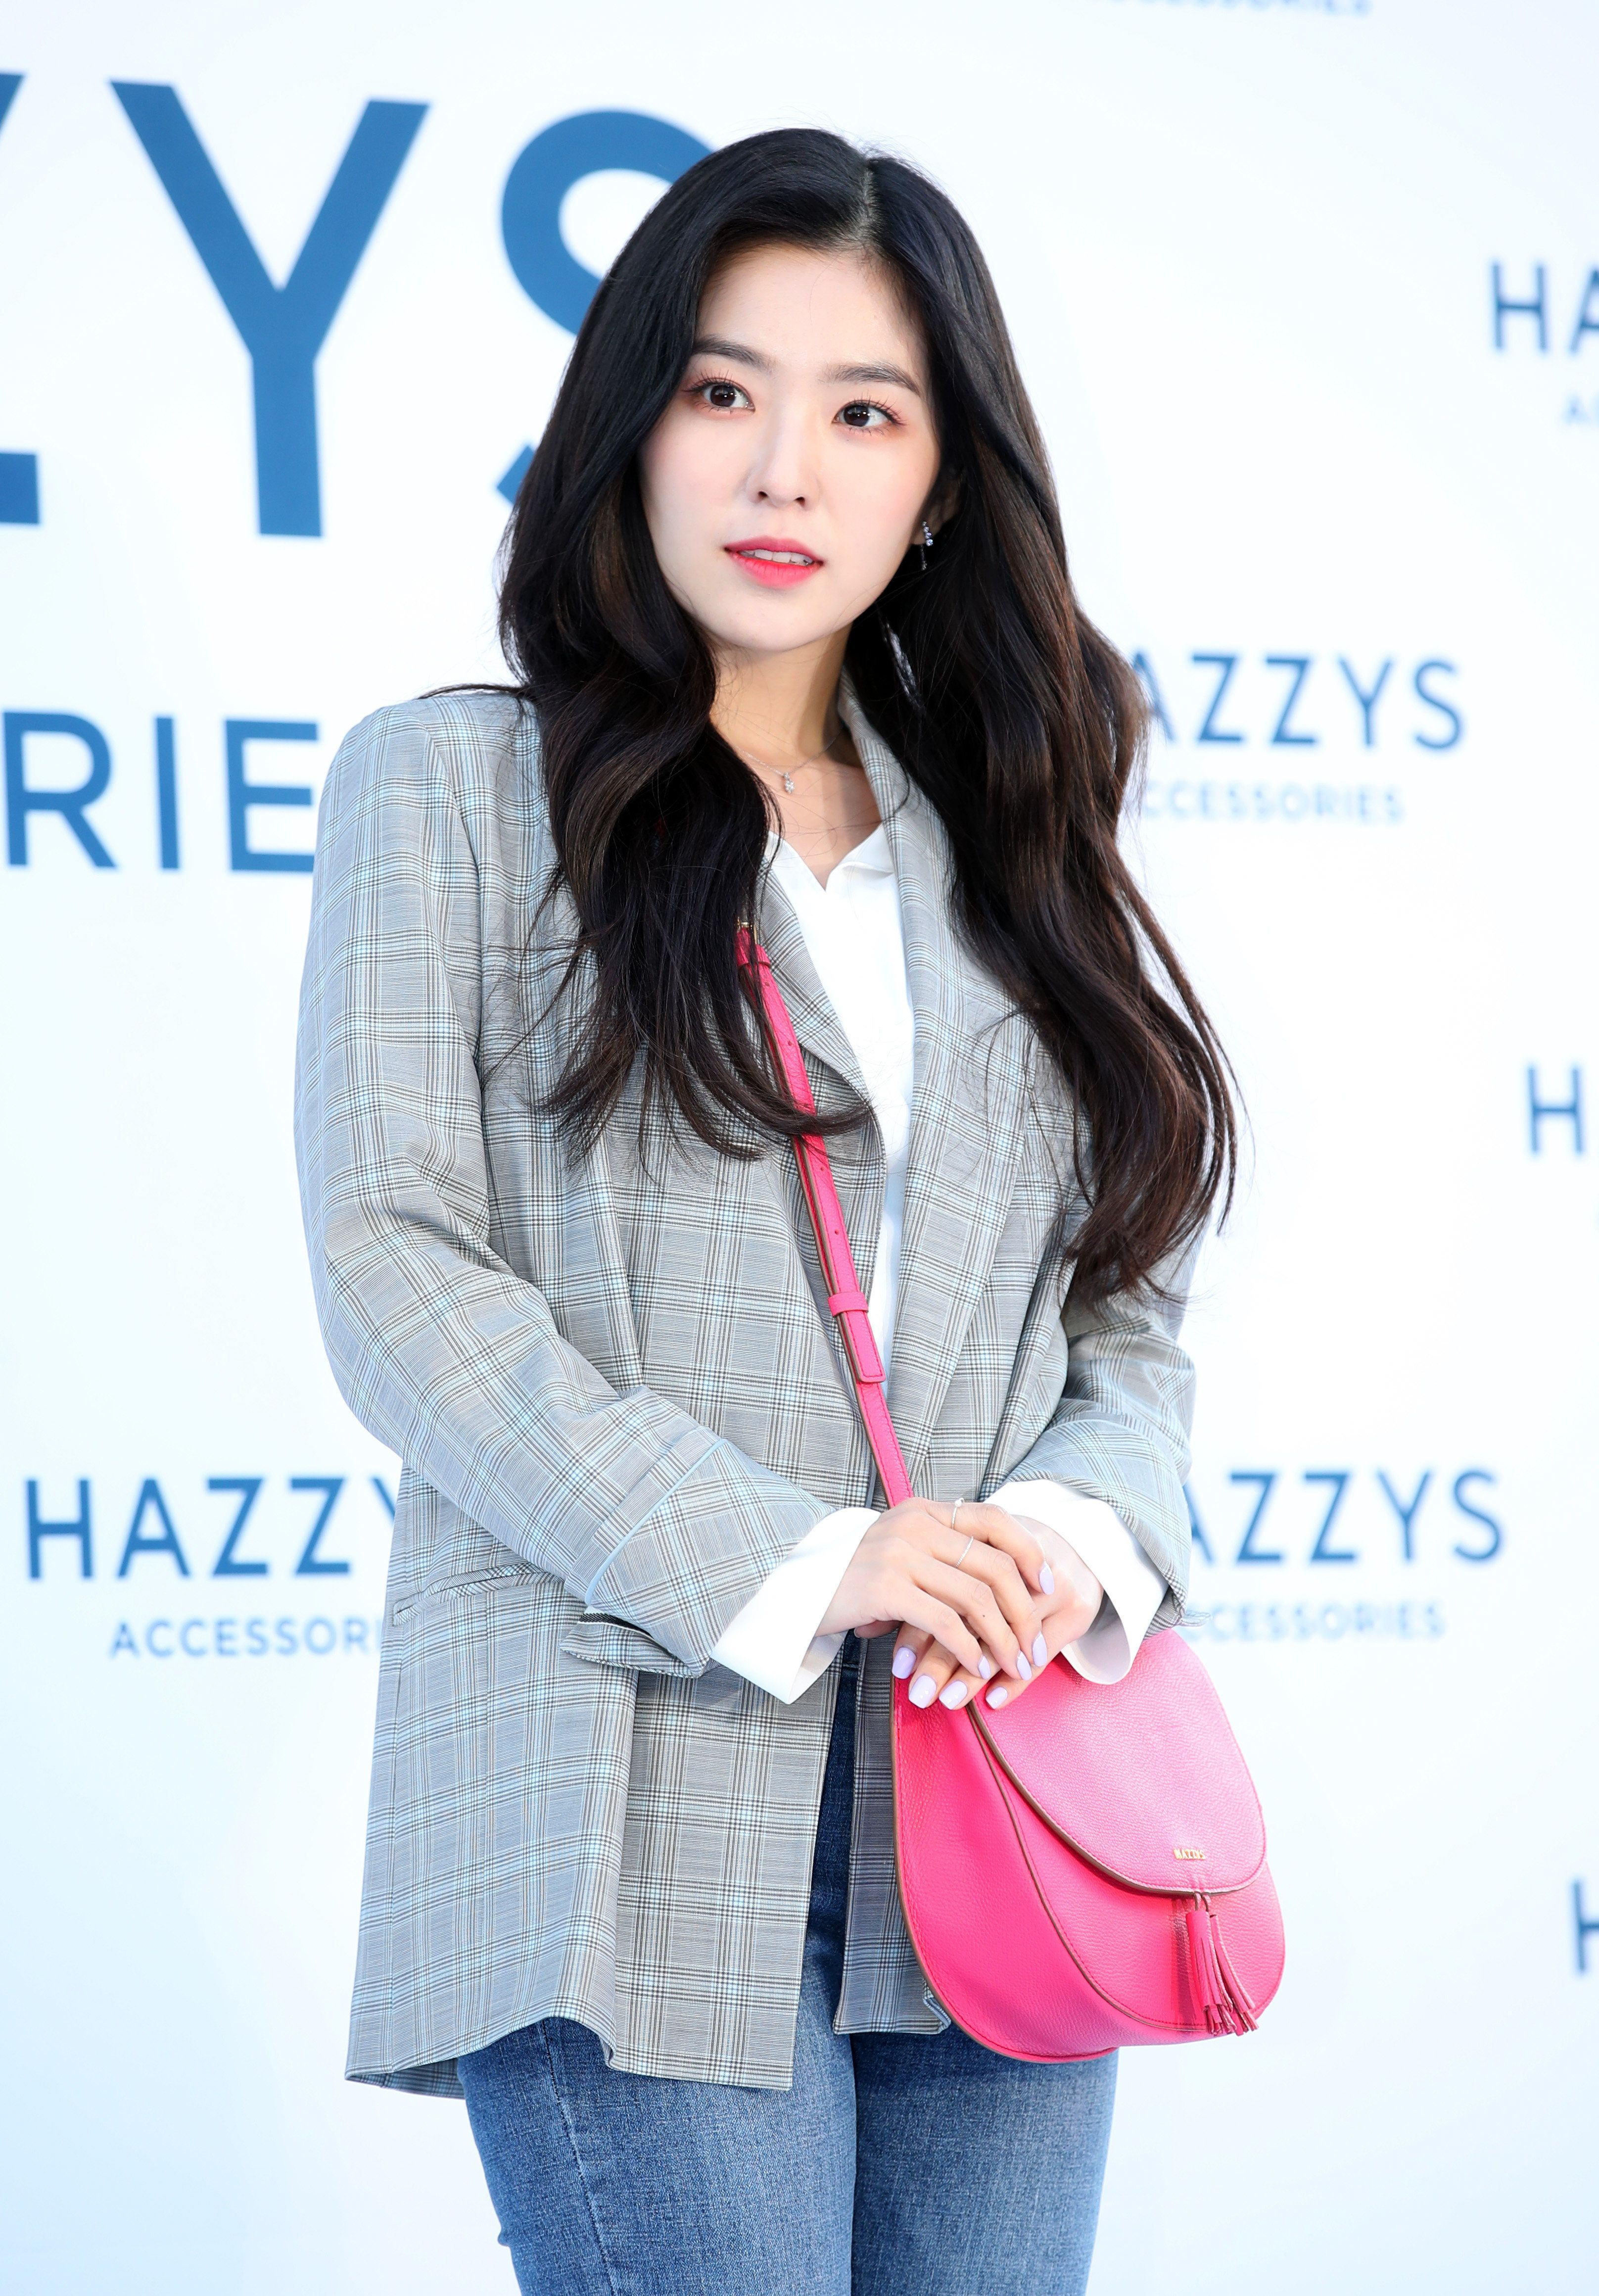

- similarity: 1.00
# Input images


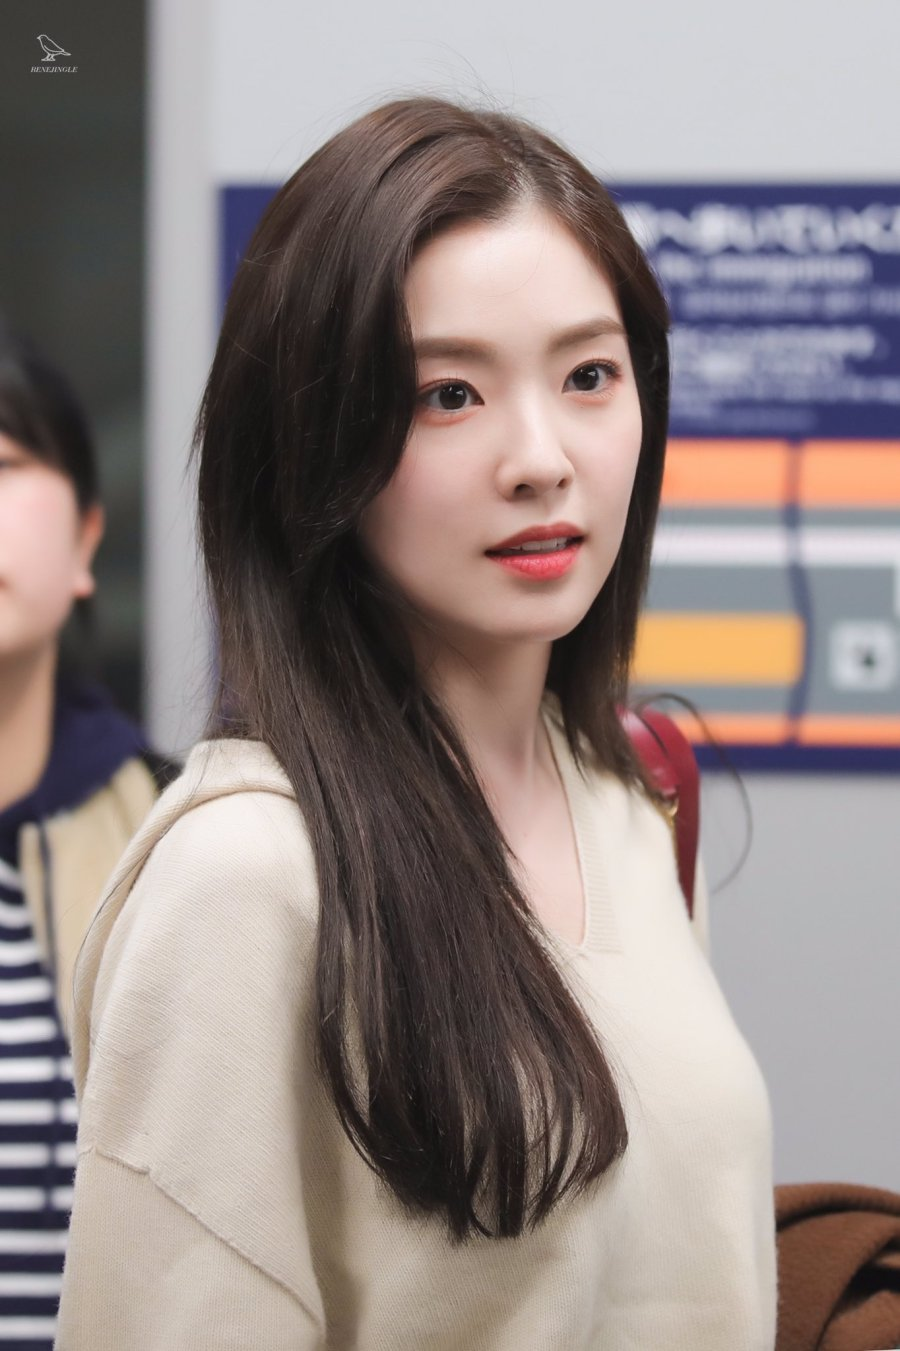

- similarity: 0.40


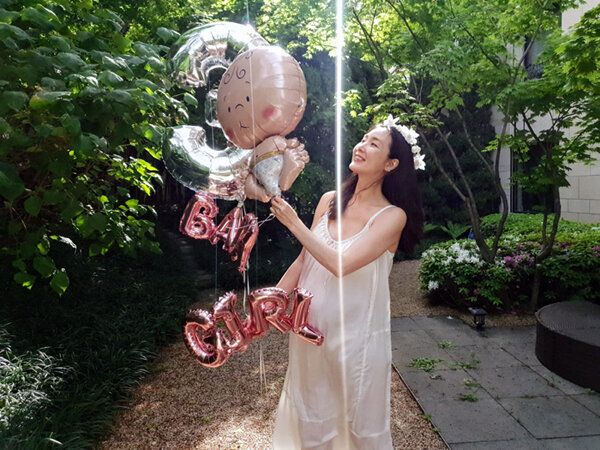

- similarity: 0.26


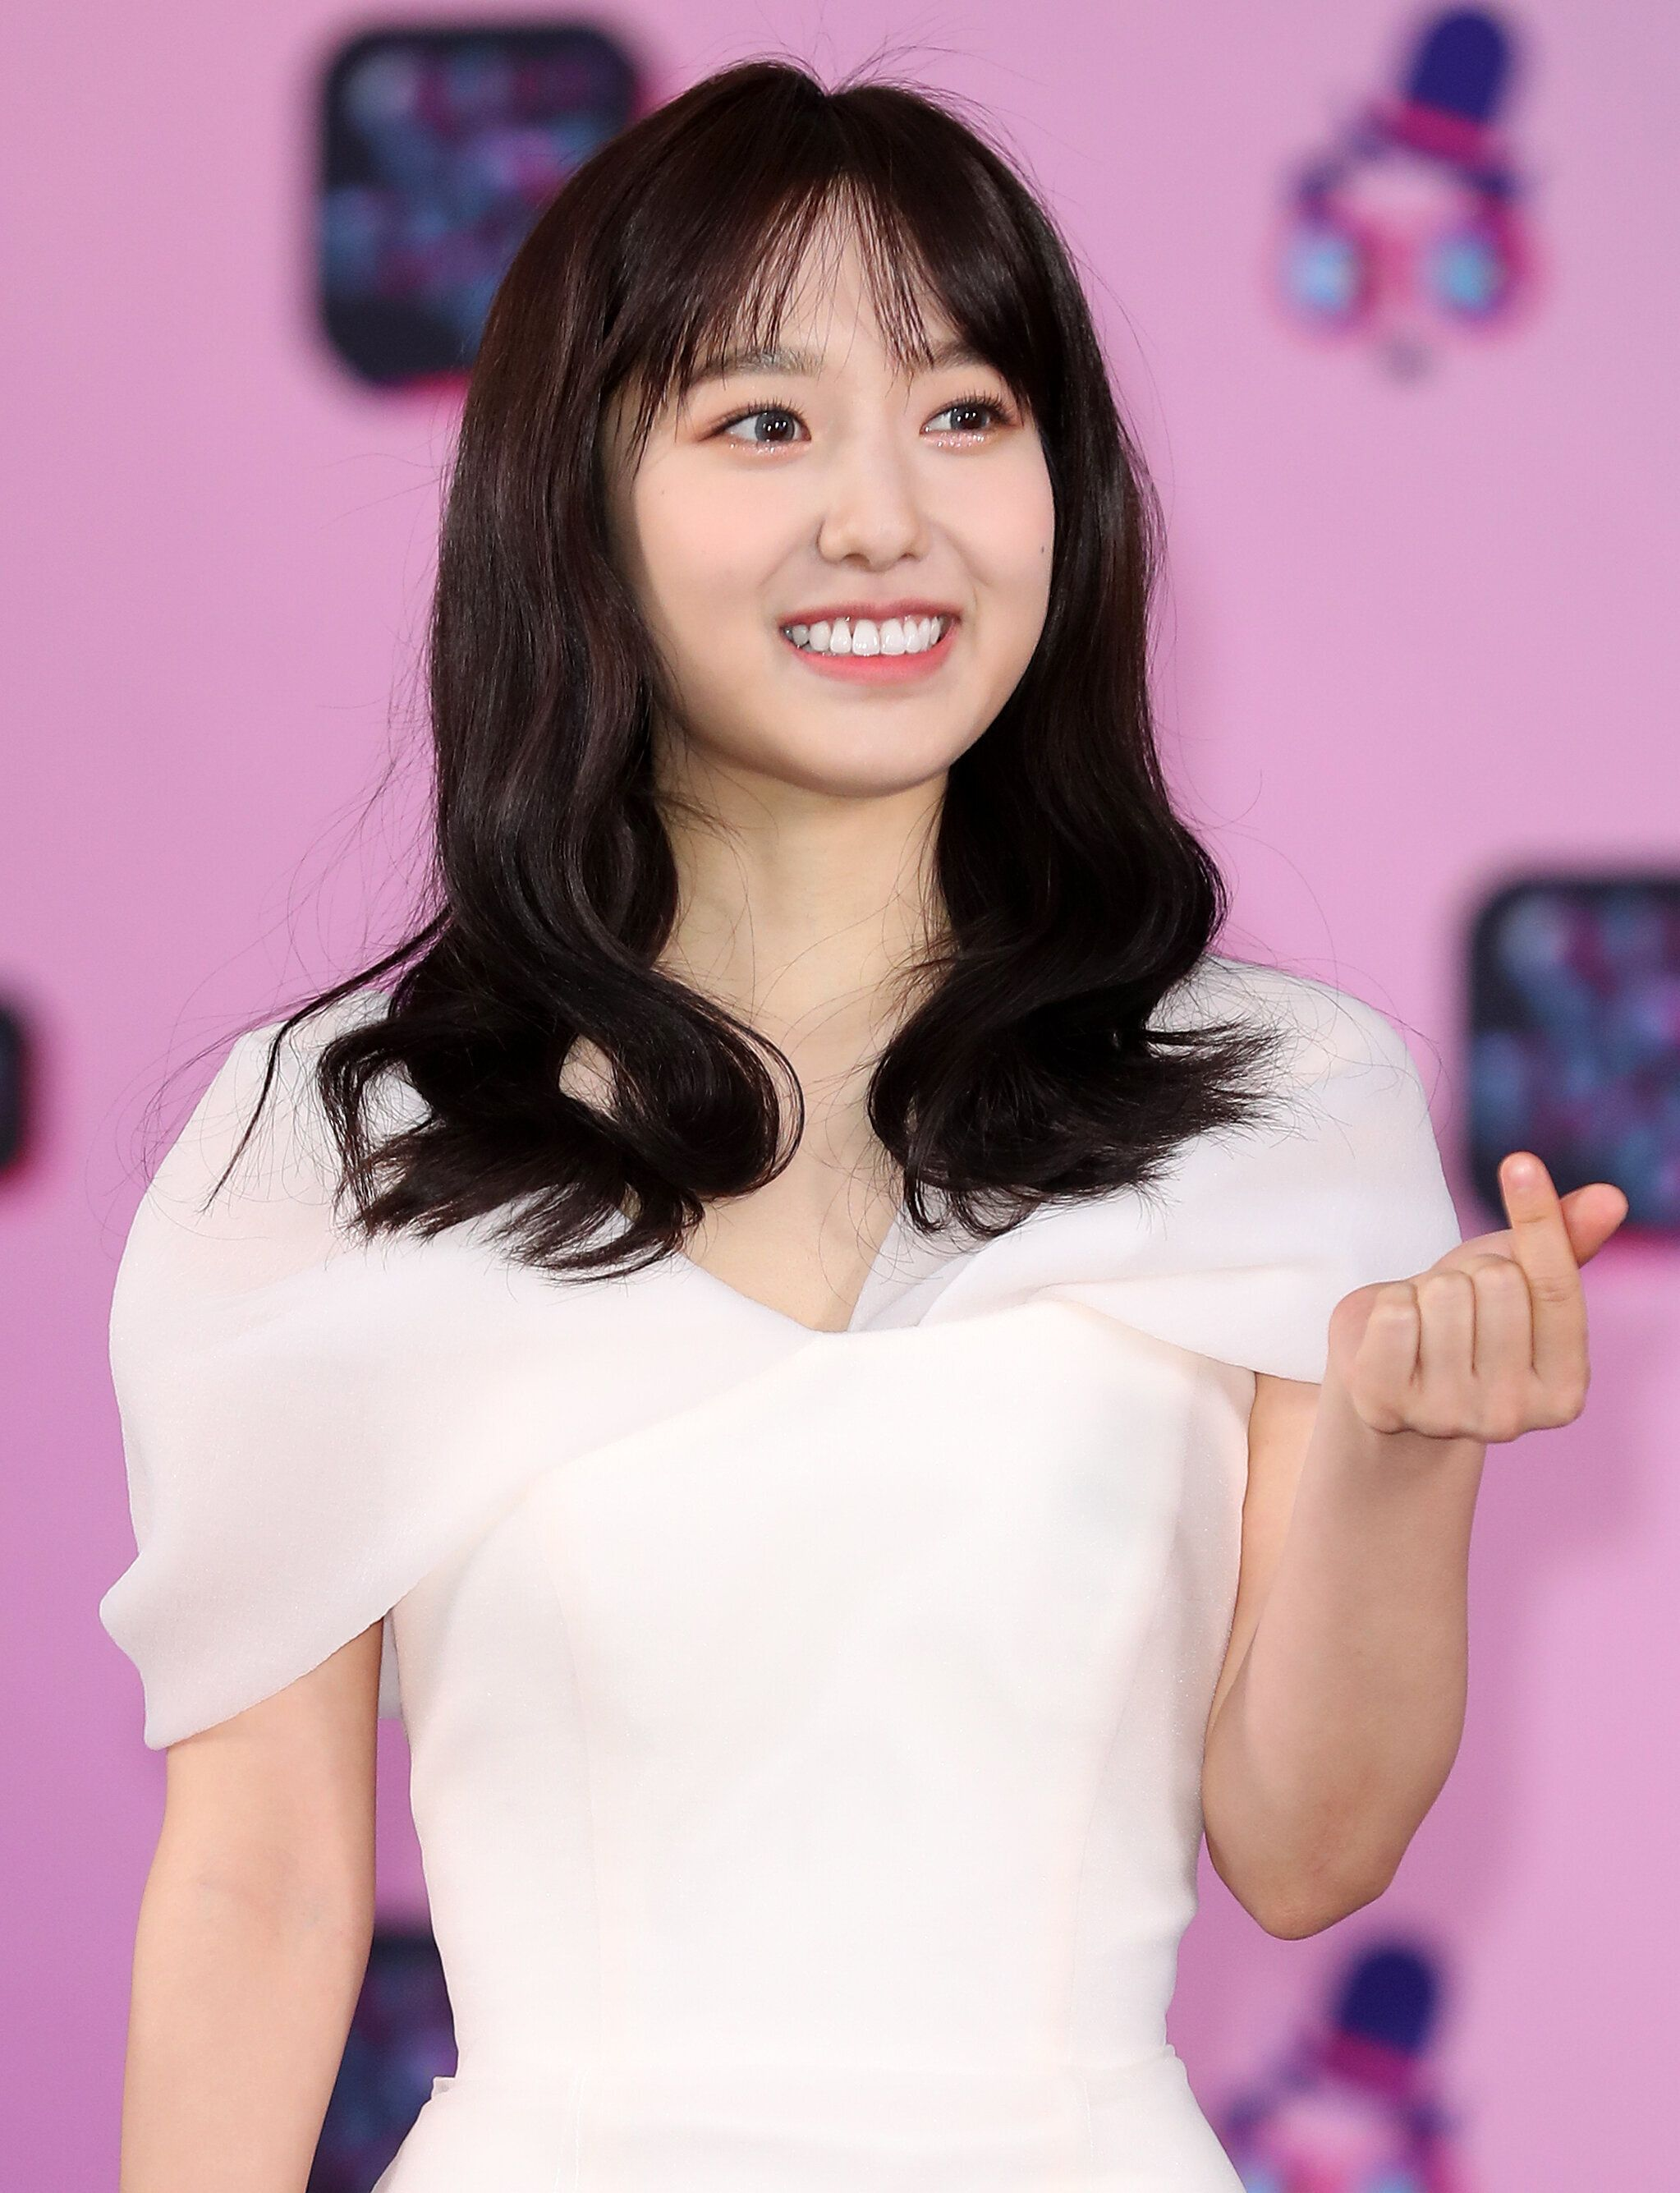

- similarity: 0.41


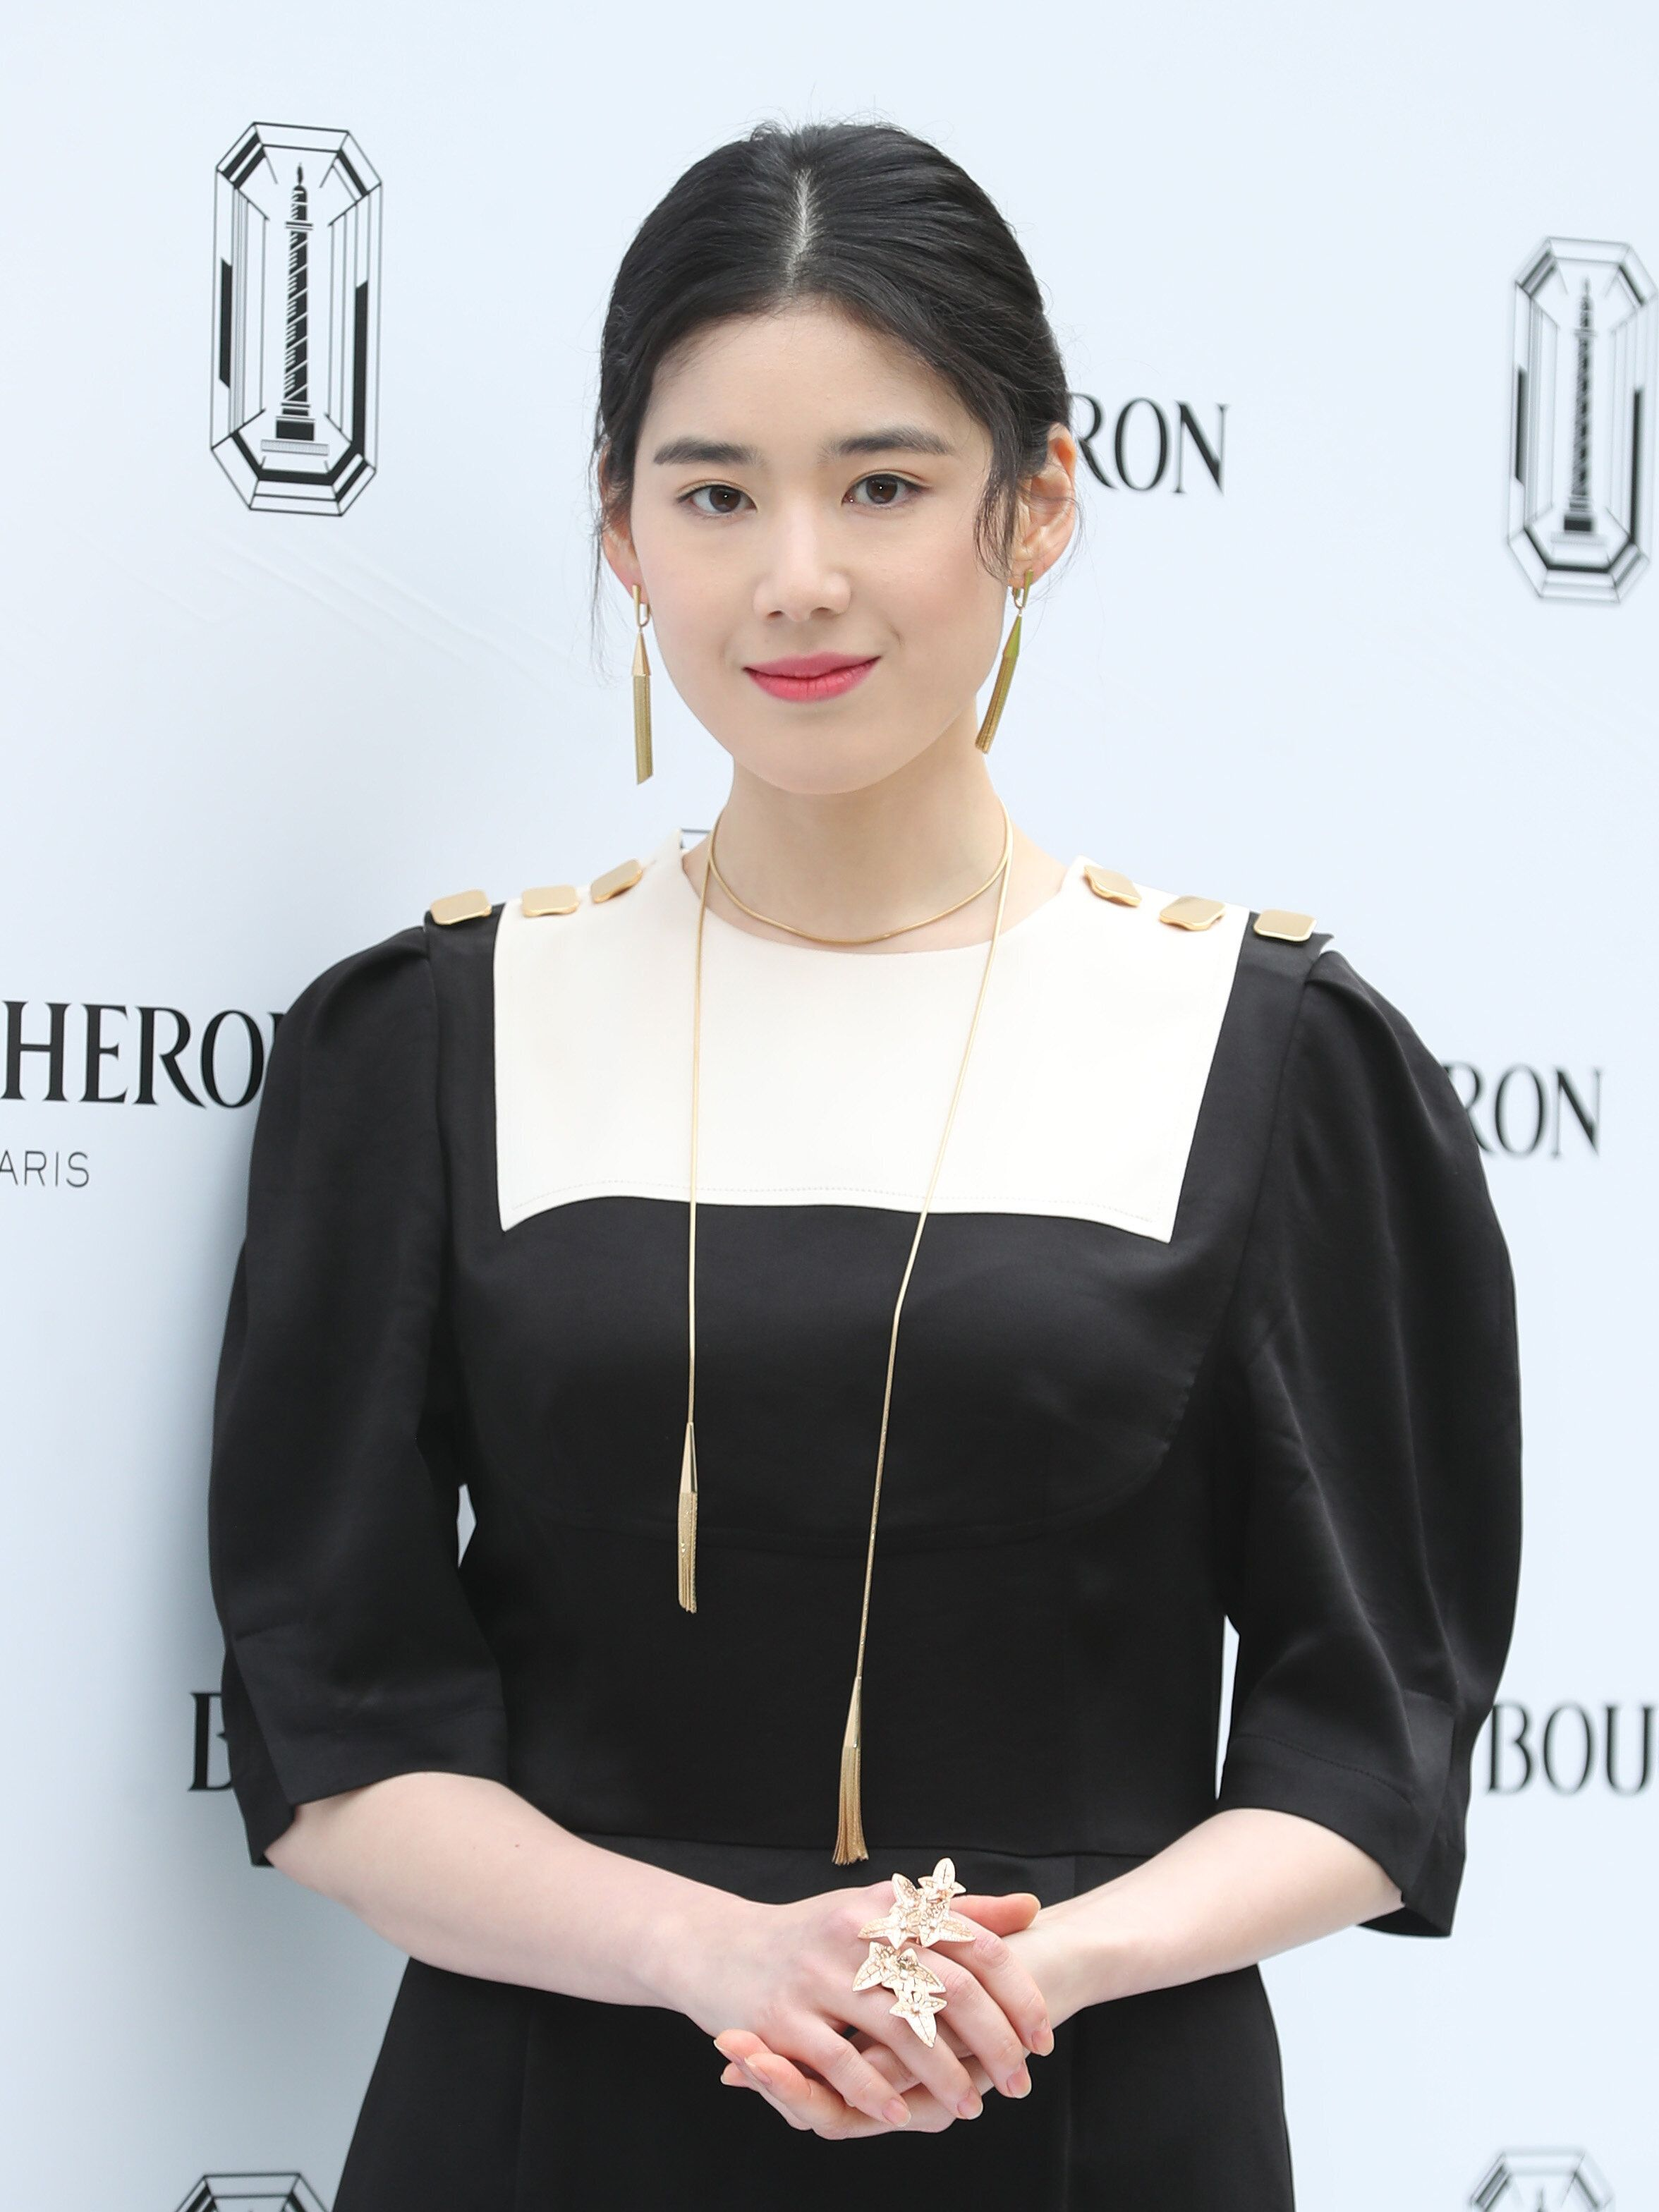

- similarity: 0.35


In [0]:
import time
import tensorflow as tf
from IPython.display import Image, display
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Load bytes of image files
image_bytes = [tf.io.gfile.GFile(name, 'rb').read()
               for name in [target_img_path] + input_img_paths]

hub_module_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_96/feature_vector/1" #@param {type:"string"}

with tf.Graph().as_default():
  input_byte, similarity_op = build_graph(hub_module_url, target_img_path)
  
  with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    t0 = time.time() # for time check
    
    # Inference similarities
    similarities = sess.run(similarity_op, feed_dict={input_byte: image_bytes})
    
    print("%d images inference time: %.2f s" % (len(similarities), time.time() - t0))

# Display results
print("# Target image")
display(Image(target_img_path))
print("- similarity: %.2f" % similarities[0])

print("# Input images")
for similarity, input_img_path in zip(similarities[1:], input_img_paths):
  display(Image(input_img_path))
  print("- similarity: %.2f" % similarity)